In [1]:
#Import packages

#basics
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
%matplotlib inline
import time
import pickle
from pprint import pprint
import gc

import warnings

#nlp
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
import re
from collections import Counter
import string
import gensim
from gensim.parsing.preprocessing import strip_numeric, strip_punctuation, strip_multiple_whitespaces, strip_short
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from preprocessor.api import clean

/home/braincourt.de/twalenczak/.local/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [27]:
#Define preprocessing function

def preprocessing(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all numbers
    2. Remove all punctuation
    3. Remove multiple whitespaces
    4. Make lowercase
    5. Returns a list of the cleaned text
    """    
    # Remove numbers
    text=[strip_numeric(sent) for sent in text]
    # Remove punctuation
    text=[strip_punctuation(sent) for sent in text]
    # Remove multiple spaces
    text=[strip_multiple_whitespaces(sent) for sent in text]
    # Concat all
    text=''.join(text)
    # Remove stop words and make lowercase
    text=[word.lower() for word in text.split() if word.lower() not in stop_words]
    # Concat all (can be omitted if I need list of individual word strings per row)
    text=' '.join(text)
    
    return text

# Load data sets

In [2]:
# Use this one bc it recognizes non-latin reviews and leaves them as empty

rows = 1000000
start_time = time.time()
with open('data/yelp_academic_dataset_review.json', encoding='ascii', errors='ignore') as infile:
    df = pd.read_json(infile, lines = True, nrows=rows)
end_time = time.time()
print("Loading reviews took", end_time - start_time, "s")

Loading reviews took 75.22487378120422 s


In [8]:
#Check data on detailed level

df.profile_report()

In [9]:
gc.collect()

139429

In [3]:
# Filter the dataset to only keep restaurant reviews
# Read in the business.json file

start_time = time.time()
business = pd.read_json('data/yelp_academic_dataset_business.json', lines = True)
end_time = time.time()
print("Loading business data took", end_time - start_time, "s")

Loading business data took 5.217515468597412 s


# Inspect business data set

In [5]:
#Check data on detailed level

business.profile_report()

In [8]:
# Drop Businesses that have no category assigned 
business = business.dropna(subset=['categories'])

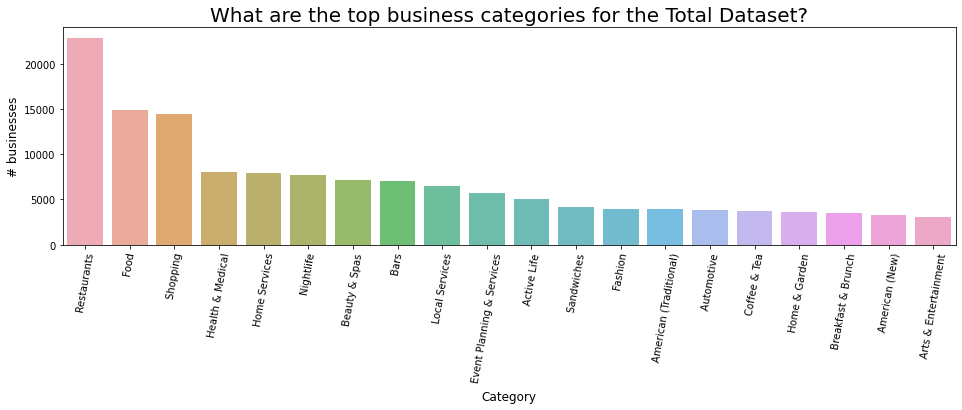

In [9]:
# Check which categories are most common
#separating column categries into string
dfbusiness_cats = ''.join(business['categories'].astype('str'))
#one category type per row
bcats=pd.DataFrame(dfbusiness_cats.split(','),columns=['categories'])

#prep for chart
y=bcats.categories.value_counts()
y=y.sort_values(ascending=False)
x=y.iloc[0:20]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("What are the top business categories for the Total Dataset?",fontsize=20)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)


plt.show()

# Most of the businesses registered are Restaurants

In [10]:
# Check how many restuarants are in there
business[business['categories'].str.contains('Restaurants', case=False, na=False)].describe()

# --> shows that 50.763 of 160.470 businesses are Restaraurants (1/3)

latitude     longitude         stars  review_count       is_open
count  50763.000000  50763.000000  50763.000000  50763.000000  50763.000000
mean      39.214873    -94.708610      3.526082    106.280480      0.630814
std        7.272312     20.390309      0.774594    206.730298      0.482589
min       28.062985   -123.349961      1.000000      5.000000      0.000000
25%       30.406856   -122.640977      3.000000     16.000000      0.000000
50%       42.240300    -84.369605      3.500000     43.000000      1.000000
75%       45.509599    -81.327349      4.000000    114.000000      1.000000
max       49.459624     71.113271      5.000000   9185.000000      1.000000

In [17]:
# Check how many food are in there
business[business['categories'].str.contains('Food', case=False, na=False)].describe()

# --> shows that 36.664 of 160.470 businesses are Food

latitude     longitude         stars  review_count       is_open
count  36664.000000  36664.000000  36664.000000  36664.000000  36664.000000
mean      39.225892    -95.548523      3.589529     80.283521      0.699296
std        7.295313     20.419302      0.864601    188.261775      0.458570
min       28.069746   -123.349961      1.000000      5.000000      0.000000
25%       30.377087   -122.648275      3.000000     11.000000      0.000000
50%       42.250007    -84.389577      3.500000     27.000000      1.000000
75%       45.511989    -81.349490      4.000000     75.000000      1.000000
max       49.459624    -70.800200      5.000000   9185.000000      1.000000

In [18]:
# how many Restaurants have also the tag of 'Food' 
rest = business[business['categories'].str.contains('Restaurants', case=False, na=False)]
rest[rest['categories'].str.contains('Food', case=False, na=False)].describe()
# --> 23.529

latitude     longitude         stars  review_count       is_open
count  23529.000000  23529.000000  23529.000000  23529.000000  23529.000000
mean      39.036764    -95.620179      3.553041    103.759786      0.676102
std        7.304676     20.212748      0.853626    222.854706      0.467972
min       28.094391   -123.349961      1.000000      5.000000      0.000000
25%       30.349912   -122.643317      3.000000     15.000000      0.000000
50%       42.162083    -84.394226      3.500000     39.000000      1.000000
75%       45.511273    -81.367959      4.000000    104.000000      1.000000
max       49.459624    -70.801143      5.000000   9185.000000      1.000000

In [19]:
# Check on second largest group according to barplot below
business[business['categories'].str.contains('Shopping', case=False, na=False)].describe()
#rest[rest['categories'].str.contains('Shopping', case=False, na=False)].describe()

# --> second largest: Shopping with 26.205 of 160.470 businesses (1/6)
# --> only 617 reviews also contain the tag restaurant

latitude   longitude       stars  review_count     is_open
count  617.000000  617.000000  617.000000    617.000000  617.000000
mean    39.540762  -98.231193    3.788493    104.411669    0.730956
std      7.533076   20.418108    0.757697    267.376308    0.443823
min     28.155976 -123.331344    1.000000      5.000000    0.000000
25%     30.373924 -122.681462    3.500000     12.000000    0.000000
50%     42.292747  -97.724749    4.000000     32.000000    1.000000
75%     45.522894  -81.467856    4.500000     94.000000    1.000000
max     49.380048  -70.853623    5.000000   4295.000000    1.000000

# Join data sets and filter on restaurants

In [12]:
# Filter out unneeded columns
business_df = business[['business_id', 'categories']]

# Merge the two dfs to find the type of business of each review
df = pd.merge(df, business_df, on='business_id', how='inner')

# --> seems like some reviews got lost because there was no category assigned to their business

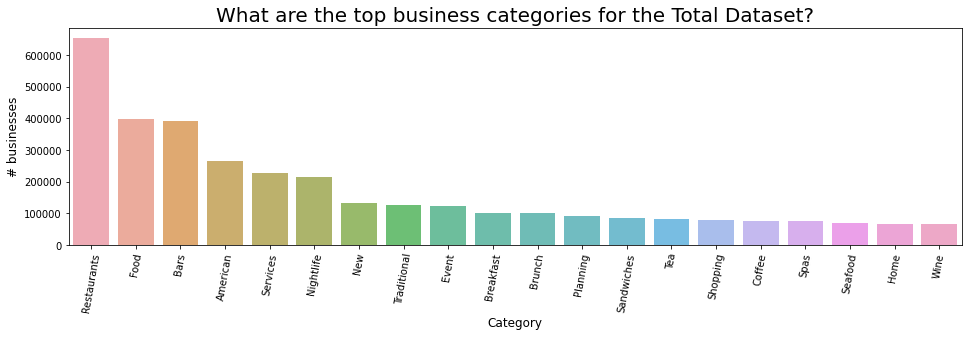

In [13]:
# Check the distribution of businesses within our review dataset
# --> check how often the keyword "Restaurant" is mentioned overall
# --> before this it occurred in combination with other words define the cuisine

#separating column categories into string
dfbusiness_cats = ' '.join(df['categories'].astype('str'))
#one category type per row
catsList = re.sub("[^\w]", " ", dfbusiness_cats).split()
bcats=pd.DataFrame(catsList,columns=['categories'])

#prep for chart
y=bcats.categories.value_counts()
y=y.sort_values(ascending=False)
x=y.iloc[0:20]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("What are the top business categories for the Total Dataset?",fontsize=20)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

plt.show()

# Seems like Restaurants have an even higher share in the review data set than in the business --> ~ 65%
# in order to have a comparable content in the review only restaurant reviews are included

In [14]:
gc.collect()

6420

In [15]:
# check how many reviews contain Restaurants as category
len(df[df['categories'].str.contains('Restaurants', case=False, na=False)])

653667

In [16]:
# drop all non-restaurant reviews
df = df[df['categories'].str.contains('Restaurants', case=False, na=False)]
df.describe()
# 653.667 reviews are left

stars         useful          funny           cool
count  653667.000000  653667.000000  653667.000000  653667.000000
mean        3.750518       0.950475       0.368469       0.451323
std         1.358993       2.431658       1.611169       1.871253
min         1.000000       0.000000       0.000000       0.000000
25%         3.000000       0.000000       0.000000       0.000000
50%         4.000000       0.000000       0.000000       0.000000
75%         5.000000       1.000000       0.000000       0.000000
max         5.000000     198.000000     255.000000     182.000000

# Quick EDA on filtered reviews

In [41]:
#Check data on detailed level

df.profile_report()

#--> shows that some rows have no text and those will be deleted

# Text Pre-processing

In [42]:
# Prepare list of stopwords for preprocessing

stop_words = set(stopwords.words('english'))            # set stopwords to English
new_words = []                                          # If needed add new stopwords to nltk list
new_stop_words = stop_words.union(new_words)
exclude_words = set(('with', 'without', 'no', 'but', 'not', "don't"))
new_stop_words = new_stop_words.difference(exclude_words)     # Remove words like 'with', 'without', 'no', etc. from stopwords list

#--> not sure if needed? so lemmatization

In [43]:
prep_text_stars = df.copy()
#prep_text_stars = pd.DataFrame(data=df.stars, columns=['stars'])
start_time = time.time()
prep_text_stars['text'] = [preprocessing(review) for review in prep_text_stars['text']]  # clean standard patterns
prep_text_stars['text'] = [clean(review) for review in prep_text_stars['text']]         # clean the social media patterns too
end_time = time.time()
print("Row-wise preprocessing took", end_time - start_time, "s")
#prep_text_stars.head()

Row-wise preprocessing took 1494.8570685386658 s


In [44]:
# Calculate review length
prep_text_stars['text length'] = prep_text_stars['text'].apply(len)
gc.collect()

181679

In [45]:
# Save preprocessed data and load it again
pickle.dump(prep_text_stars, open('data/after_preprocessing.pkl', 'wb'))

In [5]:
prep_text_stars = pickle.load(open("data/after_preprocessing.pkl", "rb"))

# Quick EDA on pre-processed data

In [47]:
prep_text_stars.profile_report()

# Data cleansing, aggregation & balancing

In [17]:
# Define outliers according to 5%-percentiles

# Define upper and lower boundaries
p95, p5 = np.percentile(prep_text_stars['text length'], [95, 5])
print(p5, p95)

# outliers of review length are dropped
indexNames = prep_text_stars[(prep_text_stars['text length'] < p5) | (prep_text_stars['text length'] > p95)].index
df_clean = prep_text_stars.copy()
df_clean.drop(indexNames, inplace=True)
df_clean.describe()
# 588.883 reviews remain

73.0 959.0


stars         useful          funny           cool  \
count  589883.000000  589883.000000  589883.000000  589883.000000   
mean        3.761946       0.871137       0.324608       0.408423   
std         1.355531       2.189376       1.452878       1.688313   
min         1.000000       0.000000       0.000000       0.000000   
25%         3.000000       0.000000       0.000000       0.000000   
50%         4.000000       0.000000       0.000000       0.000000   
75%         5.000000       1.000000       0.000000       0.000000   
max         5.000000     198.000000     255.000000     182.000000   

         text length  
count  589883.000000  
mean      311.371119  
std       202.540237  
min        73.000000  
25%       153.000000  
50%       252.000000  
75%       419.000000  
max       958.000000

In [18]:
# Augment another aggregated class positive, neutral & negative rating
classes_dict = {
    5 : 'positive',
    4 : 'positive',
    3 : 'neutral',
    2 : 'negative',
    1 : 'negative'}

df_clean['classes'] = [classes_dict[x] for x in df_clean.stars]

In [19]:
# 2 step balancing of dataset
# 1.: Create a balanced dataset of 20.000 reviews for each rating
df_bal = df_clean.groupby('stars', group_keys=False).apply(lambda x: x.sample(min(len(x), 20000), random_state=42))

# 2.: Create a balanced dataset of 20.000 reviews for each rating class
df_bal = df_bal.groupby('classes', group_keys=False).apply(lambda x: x.sample(min(len(x), 20000), random_state=42))

# Write data to file

In [20]:
# Create new df with only meaningful columns

df_bal = df_bal[['stars', 'text', 'classes', 'text length']]

In [21]:
# Create an text only object containing all reviews

text = ''.join(df_bal.text)

In [22]:
#Write data to pickle file

pickle.dump(df_bal, open('data/preprocessed_text.pkl', 'wb'))
pickle.dump(text, open('data/preprocessed_all_text.pkl', 'wb'))

In [23]:
gc.collect()

0